# Fitting a line to correlated Gaussian data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import oktopus
from oktopus import MultivariateGaussianPosterior, MultivariateGaussianLikelihood, UniformPrior, JointPrior
from oktopus.models import ExpSquaredKernel, WhiteNoiseKernel

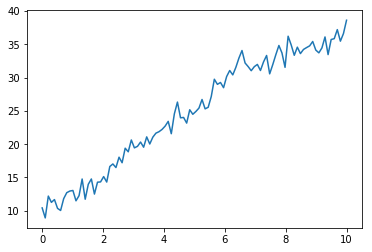

In [2]:
x = np.linspace(0, 10, 100)
def mean(m, b):
    return m * x + b
def cov(k, l, s):
    return ExpSquaredKernel(x).evaluate(k, l) + WhiteNoiseKernel(len(x)).evaluate(s)
np.random.seed(2)
fake_data = np.random.multivariate_normal(mean(3, 10), cov(1, 1, 1))
plt.plot(x, fake_data)

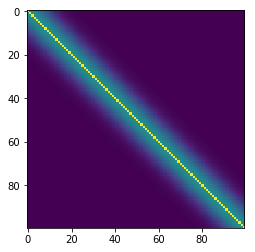

In [3]:
plt.imshow(cov(1, 1, 1))

In [4]:
prior_m = UniformPrior(1, 5, 'm')
prior_b = UniformPrior(4, 15, 'b')
prior_k = UniformPrior(0, 2, 'k')
prior_l = UniformPrior(0, 2, 'l')
prior_s = UniformPrior(0, 2, 's')
prior = JointPrior(prior_m, prior_b, prior_k, prior_l, prior_s)
prior.evaluate((2.5, 11, 1.3, 1.5, 0.7))

5.8636311755980977

In [5]:
posterior = MultivariateGaussianPosterior(fake_data, mean, cov, 2, prior)

In [6]:
map_est = posterior.fit(x0=(2.5, 11, 1.3, 1.5, 0.7))
map_est

 final_simplex: (array([[  2.8616171 ,  10.45113443,   1.46007457,   1.03220664,
          1.00774554],
       [  2.86161429,  10.45108805,   1.4601245 ,   1.03220865,   1.0077506 ],
       [  2.86159851,  10.45112327,   1.46012812,   1.03219364,
          1.00775552],
       [  2.86161999,  10.45105247,   1.45997464,   1.03223138,
          1.00774056],
       [  2.86162479,  10.45108222,   1.46008339,   1.03219434,   1.00775   ],
       [  2.86161904,  10.45108653,   1.46007595,   1.032203  ,
          1.00776055]]), array([ 136.92914479,  136.92914479,  136.92914481,  136.92914481,
        136.92914481,  136.92914481]))
           fun: 136.92914478873888
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 168
        status: 0
       success: True
             x: array([  2.8616171 ,  10.45113443,   1.46007457,   1.03220664,   1.00774554])

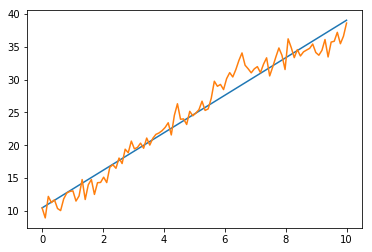

In [7]:
plt.plot(x, mean(*map_est.x[:2]))
plt.plot(x, fake_data)

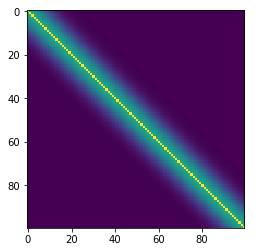

In [8]:
plt.imshow(cov(*map_est.x[2:]))

In [9]:
import emcee
ndim, nwalkers = 5, 100
p0 = [map_est.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda params: - posterior.evaluate(params))
sampler.run_mcmc(p0, 5000)

(array([[  2.78834814,  10.94548524,   0.98332529,   1.20173277,
           1.00777733],
        [  3.04404359,   9.48444025,   1.48149914,   1.06721849,
           1.01160923],
        [  3.05601472,   9.48520599,   1.99176883,   0.90502578,
           1.05418273],
        [  2.92574075,  10.519467  ,   1.9023004 ,   0.87437415,
           1.05048481],
        [  2.84796989,  10.31926322,   1.46898073,   1.16784991,
           1.06063708],
        [  2.77238858,  10.64424208,   1.80818254,   1.02166068,
           0.96386877],
        [  2.76657137,  10.86992998,   1.1278648 ,   1.14430799,
           0.98745595],
        [  2.89245145,  10.42008868,   0.89965328,   0.9294487 ,
           0.99063383],
        [  2.92748307,  10.03641259,   1.2883563 ,   1.02715326,
           1.03917436],
        [  3.20567144,   9.20305206,   1.75976449,   0.75447303,
           1.00094429],
        [  3.03525812,  10.39611031,   1.50247874,   1.08832332,
           0.94161381],
        [  3.06750655

In [11]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples.shape

(495000, 5)

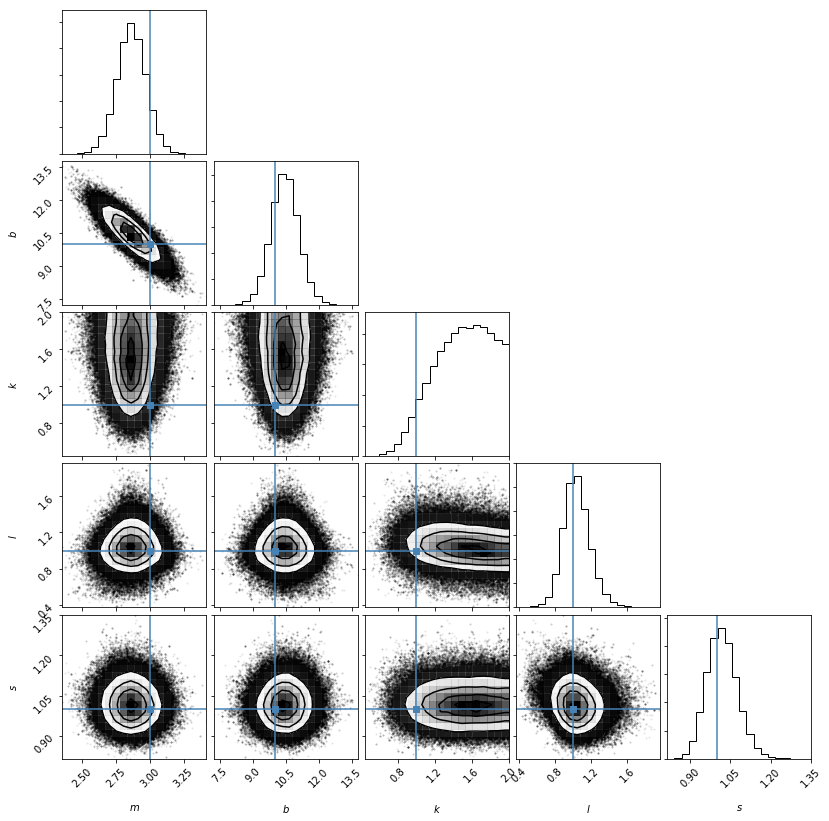

In [12]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$k$", "$l$", "$s$"],
                    truths=[3, 10, 1, 1, 1])

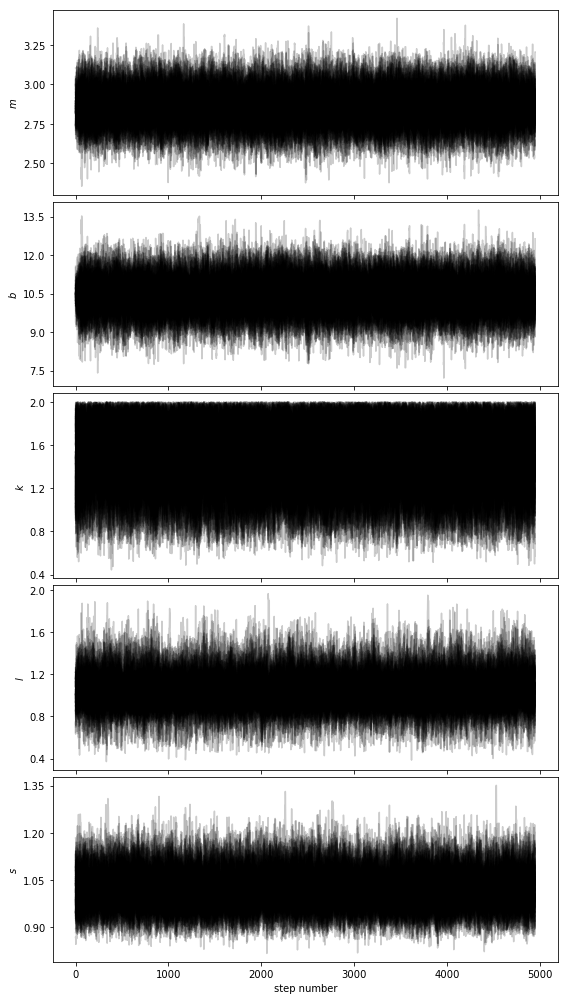

In [13]:
from matplotlib.ticker import MaxNLocator
label = ["$m$", "$b$", "$k$", "$l$", "$s$"]

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 14))
for i in range(0, 5, 1):
    axes[i].plot(sampler.chain[:, 50:, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(label[i])

axes[4].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)